In [1]:
import pretty_midi
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import os
import random

os.environ["CUDA_VISIBLE_DEVICES"] = '3'

import sys

# Download midi library from here: http://deeplearning.net/tutorial/rnnrbm.html
# and do sysn.path.append with it, like below.
# Direct link: http://www.iro.umontreal.ca/~lisa/deep/midi.zip
sys.path.append("/home/daniil/projects/rnns/midi/")
from utils import midiread, midiwrite
import pretty_midi


class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        
        logits_flatten = binary_logits.view(-1, 2)
        
        return logits_flatten, hidden

In [42]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()


In [43]:
rnn.load_state_dict(torch.load('models/music_rnn_nottingham_512.pth'))

In [44]:
def sample_from_piano_rnn(sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())

    final_output_sequence = [current_sequence_input.data.squeeze(1)]
    
    hidden = None

    for i in xrange(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

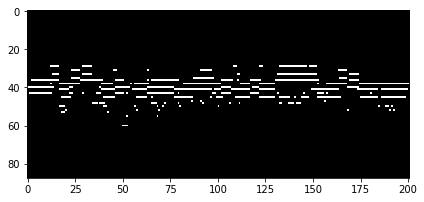

In [45]:
%matplotlib inline

import skimage.io as io

sample = sample_from_piano_rnn(sample_length=200, temperature=0.7).transpose()
io.imshow(sample)

In [46]:
midiwrite('sample.midi', sample.transpose(), dt=0.3)

In [47]:
import IPython.display

midi = pretty_midi.PrettyMIDI('sample.midi')


# Get an .sf2 piano sounds library, for example here https://sites.google.com/site/soundfonts4u/
# Or replace the next line with:
# audio = midi.fluidsynth(fs=12000)
audio = midi.fluidsynth(fs=12000, sf2_path='../../piano.sf2')

IPython.display.Audio(audio, rate=12000)